# **Introduction to Bayesian Reasoning** (Part 2)

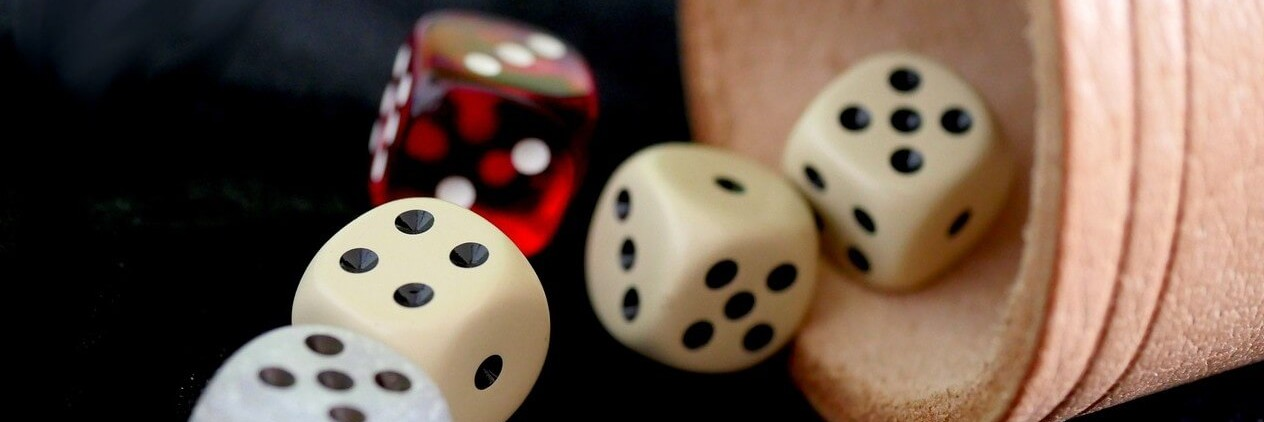

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Probabilistic_Thinking_and_Programming/Probabilistic_Thinking_and_Programming_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:** Sicelukwanda Zwane, Elizaveta Semenova, Josie Rey, Kira Düsterwald & James Allingham

**Reviewers:** Ruan van der Merwe, Tali Beynon, Ruan de Kock  & Mohamed Serrhini


**Previously...**

(Summary goes here)

In this second part of the practical, we will look at Bayesian inference and a powerful paradigm called probabilistic programming.


**Aims/Learning Objectives:**

* [<font color='orange'>`Intermediate`</font>] Understand the difference between MLE, MAP, and Bayesian learning.
* [<font color='green'>`Advanced`</font>] Understanding the challenges involved in computing Bayes rule and how probabilistic programming solves these.
* [<font color='green'>`Advanced`</font>] Be able to implement a simple probabilistic program with `numpyro`.

**Prerequisites:**

* Basic machine learning (e.g., simple supervised and unsupervised machine learning techniques).
* Basic calculus (e.g., computing an integral and taking derivatives to solve min/max optimisation problems).
* Python programming (with `jax` and `numpy`).

**Outline:**

Have a look at the Table of Contents for a more comprehensive outline but, in short, today's practical consists of two parts: [Bayesian inference](#scrollTo=P8Tc509dapfl) and [Probabilistic programming](#scrollTo=2Tz_surdH7AE) \😀/


**Before you start (Instructions for Google Colab):**

This practical does not require a GPU or TPU, so feel free to use a CPU runtime: "Runtime" > "Change runtime type" > "CPU".

**Important:** you will also need to go to "Tools" > "Settings" > "Miscellaneous" > check "Crab Mode".

>[Introduction to Bayesian Reasoning (Part 2)](#scrollTo=oXhUKM4pmkGc)

>>[Installation and Imports](#scrollTo=6EqhIg1odqg0)

>[Part A: Bayesian Inference: What, Why, How](#scrollTo=P8Tc509dapfl)

>>[What is Bayesian inference?](#scrollTo=DbsLMPwJH6_u)

>>[⭐ Bayes' Theorem](#scrollTo=kd0-IZ3iH6_v)

>>[The Prior: Bayesian Inference](#scrollTo=x4TZ2JnkH6_x)

>>[💭 How can we perform true Bayesian inference?](#scrollTo=0rky6ZLxH6_3)

>>[Analytical Bayesian inference](#scrollTo=9hle0E-kH6_3)

>>[Regularisation and Maximum Posterior Estimation](#scrollTo=VGbvL5lA3RQN)

>>[Deriving MAP](#scrollTo=I_e1kgDKAzeS)

>>[Sampling](#scrollTo=pBiZ2I11w6MI)

>[Part B: Probabilistic Programming](#scrollTo=2Tz_surdH7AE)

>>[Probabilistic programming languages (PPLs)](#scrollTo=LSfRig4KH7AE)

>>[🤖 Introduction to NumPyro](#scrollTo=rHChgNuyH7AE)

>>[🧮 Bayesian Linear regression](#scrollTo=WkecBz48H7AJ)

>[💎 Final Words](#scrollTo=4-QOIDwUyCSp)

>>[📚 Resources](#scrollTo=YfL4h4y9QUPt)



## **Installation and Imports**

Run the following cells to set up our working environment and helper functions.

In [ ]:
## Install and import anything required. Capture hides the output from the cell.

!pip install numpyro

import jax
from jax import random
import jax.numpy as jnp
from jax import random

import numpyro
numpyro.enable_validation()

# ^ This allows numpyro to check e.g., if x is in the domain of a uniform dist.
# Since speed isn't a requirement for a tutorial, let's keep it on.
import numpyro.distributions as dist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

import numpy as np
import random as rnd

from scipy.stats import gaussian_kde
import scipy.stats as stats
import math
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# adapts colours for theme
from google.colab import output
is_dark = output.eval_js('document.documentElement.matches("[theme=dark]")')

if(is_dark):
  prior_col = 'yellow'
  post_col = 'cyan'
  like_col = 'pink'
else:
  prior_col = 'purple'
  post_col = 'gray'
  like_col = 'teal'

# **Part A: Bayesian Inference: What, Why, How**

[<font color='blue'>`Beginner`</font>] /[<font color='orange'>`Intermediate`</font>]

_Note: Most of this section is aimed at an [<font color='orange'>`Intermediate`</font>] level, however, the initial conceptual content is certified [<font color='blue'>`Beginner`</font>] friendly! 🤙 So if you are a beginner, see how far you can get up until the **point estimates** section. If you have some knowledge of calculus and optimisation, the point estimates section will also be accessible. Remember to ask your tutors for help if you get stuck along the way!_

There are **several different approaches** to **probabilistic thinking**. Before we discuss Bayesian inference, let's consider how three schools of thought might approach finding the probability of a coin flip's outcome.

1) **Classical approach** (*theory-driven*): "In a coin flip (assuming a fair coin), there are two outcomesL: heads or tails. Therefore, the likelihood of heads is $\frac{1}{2}$, or $p=0.5$."

2) **Frequentist approach** (*multiple trials*): "We carry out a coin flip experiment 100 times and notice that the probability of heads approaches, but is not exactly, $p=0.5$. We reason that, with an infinite number of trials, the likelihood of heads approaches $p=0.5$, and so this is the event's probability.

3) **Bayesian approach** (*incorporates prior beliefs*): "We have some belief about the likelihood of a particular outcome. We carry out a series of coin flips to capture observed data and bring this together with our prior knowledge. This updated model then represents the probability of our possible coin flip outcomes."

Which of these approaches to use varies between probabilistic problems. While the classical and frequentist approaches are likely most suitable in this example, there are many cases where a Bayesian perspective is incredibly powerful.

So, with this in mind, let's dive into the world of Bayesian inference!

**What you will learn:**

- What is Bayesian inference?
- Why is it important/useful?
- How to perform Bayesian inference: the painful (old) way and a modern way... 😮

## ***What* is Bayesian inference?**



In short, Bayesian inference is the process of deducing properties of a probability distribution from data using Bayes’ theorem. It incorporates the idea that probability should include a measure of <font color='purple'>`belief`</font> 💭 about a prediction or outcome.

Bayesian inference is a method of statistical inference in which probability is used to <font color='purple' >`update beliefs`</font> about model's parameters based on available <font color='red'>`evidence or data`</font> 📁.

This is important in real world scenarios where prior beliefs must be incorporated in a model.

### 🔧 **Group Task (A1)**

To better understand the role of prior <font color='purple'>`beliefs and subjective probability`</font>, discuss with your neighbour the following questions:


- What is the probability that it will rain tomorrow?
- What is the probability that the next president will be a woman?
- What is the probability that aliens built the pyramids?

How do these questions compare to the probability that a die will roll a 6?

Such questions, unlike the die, cannot be answered by "long-run" probability, i.e., probability obtained from multiple repeated runs of the same experiment. A certain degree of <font color='purple'>`belief`</font> 💭 is involved.

<font color='purple'>`Priors`</font> 💭 and "subjective" probability are foundational for Bayesian inference!


## ⭐ **Bayes' Theorem**

_Note: Conditional probability is the axis on which Bayesian statistics turns! We do assume some prior knowledge of joint and conditional probabilities in the following section, so please refresh your knowledge of this before proceeding, if needed!_

Let's suppose we are interested in knowing the chance of lightning 🌩 given that we observe rain 🌧.

From the **Chain rule of probability**, we know that if 🌧 and 🌩 are random variables, we can write their joint probability as follows:

\begin{equation}
\large p(🌧, 🌩) = p(🌧 \mid 🌩)p(🌩)
\end{equation}

Alternatively, we can write the joint distribution as:

\begin{equation}
\large p(🌧, 🌩) = p(🌩 \mid 🌧)p(🌧)
\end{equation}

Combining these two equations, we obtain a formula for relating the two conditional probabilities:

\begin{equation}
\Large p(🌩 \mid 🌧) = \frac{p(🌧 \mid 🌩)p(🌩)}{p(🌧)}
\end{equation}

This is the famous **Bayes' Theorem!** ⭐

Why is it so famous? Well let's understand what it means and gives us first!

---


### **Prior, Likelihood and Posterior**

Bayes' Theorem is commonly seen in machine learning and other models that treat the <font color='red'>`data`</font> $\mathcal{D}$ and <font color='purple'>`parameters`</font> $\theta$ which belong to some <font color='blue'>`model class`</font> as random variables:

\begin{equation}
\Large \underbrace{p(\theta \mid \mathcal{D})}_{\text{Posterior}} = \frac{\overbrace{p(\mathcal{D} \mid \theta)}^{\text{Likelihood}}\, \overbrace{p(\theta)}^{\text{Prior}}}{\underbrace{p(\mathcal{D})}_{\text{Evidence}}}
\end{equation}

Each quantity/term in Bayes' Theorem has a special name.

* $p(\mathcal{\theta})$ is the <font color='purple'>`prior`</font>. The prior is a distribution which reflects what we may know about how the model parameters are distributed. If we know nothing about the model parameters, we may choose an non-informative prior, such as the Uniform prior. Otherwise, if we are super sure about how the parameters are distributed, we may choose a very specific prior distribution such as [the Kent distribution](https://en.wikipedia.org/wiki/Kent_distribution) (_you do not need to know what this is_).

* $p(\mathcal{D} \mid \theta)$ is the <font color='teal'>`likelihood`</font> . The likelihood tells us _"how likely"_ we are to observe the data if we plug the given parameter values $\theta$ into the <font color='blue'>`model class`</font>.
We are usually interested in finding model parameters that give a high likelihood score. We discuss this in more detail in the **Maximum Likelihood Estimation** section.

* and $p(\theta \mid \mathcal{D})$ is the <font color='pink'>`posterior`</font>. We can think of the posterior probability as the "updated prior distribution" over $\theta$ after we have observed the data $\mathcal{D}$. Parameter values that have a high probability of reproducing the data will also have a high posterior probability $p(\theta \mid \mathcal{D})$.

* The denominator $p(\mathcal{D})$ is often called a *normaliser* or <font color='red'>`evidence`</font> . It ensures that the posterior <font color='pink'>`posterior`</font> $p(\theta \mid \mathcal{D})$ is a valid distribution, i.e., has an integral of 1. For this reason, you will often see Bayes rule summarised as "<font color='pink'>`posterior`</font> $\propto$ <font color='purple'>`prior`</font> $\times$ <font color='teal'>`likelihood`</font> ", which ignores the denominator since it is a constant (independent of $\mathcal{\theta}$). This posterior summarises our belief state about the possible values of $\theta$.

We can also write Bayes' Theorem as:

\begin{equation}
\Large \underbrace{p(\theta \mid \mathcal{D})}_{\text{Posterior}} = \frac{\overbrace{p(\mathcal{D} \mid \theta)}^{\text{Likelihood}}\, \overbrace{p(\theta)}^{\text{Prior}}}{\underbrace{\int p(\mathcal{D} \mid \theta)\, p(\mathcal{\theta})d\theta}_{\text{Evidence}}}
\end{equation}

where we express the <font color='red'>`evidence`</font> $p(\mathcal{D})$ as a the **marginalisation** of the model parameters from the numerator $p(\mathcal{D} \mid \theta)p(\theta)$. As such, the <font color='red'>`evidence`</font> is sometimes called the **marginal likelihood**. _Remember that the integral becomes a summation when we consider discrete random variables!_


### 🔧 **Group Task (A2)**

* Switch $A$ and $B$ in $\
p(B \mid A) = \frac{p(A \mid B)p(B)}{p(A)}$ and label what is the posterior, likelihood, prior and evidence in the new equation.
* Explain what each means to each other a few times to be sure you know what goes where!

_Often the literature will refer to these 'labels' and require you know them already, so while they might seem arbitrary this memorisation task goes a long way to making your life easier in practice!_

#### 💡 **Answer (A2)**

In a picture format:

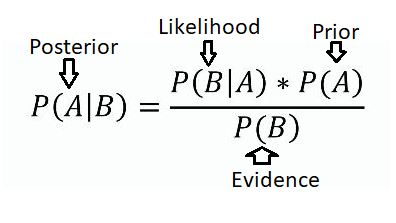


To reiterate:

- Prior is what is known or estimated a priori
- Likelihood is probability of data given parameters of interest
- Posterior is probability of parameters of interest given data

## **The Prior: Bayesian Inference**

Let's get to grips with these concepts a bit more by thinking about some everyday examples!


<div align="center">

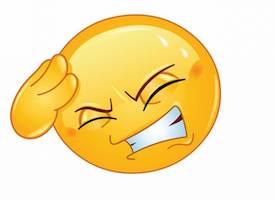
</div>

Imagine a situation where you need make a decision concerning your health. You have a headache, and can choose between two doctors:

**Doctor 1:**
- Has a mental model for the cause of pain.
- Performs tests.

**Doctor 2:**
- Has a mental model for the cause of pain.
- Has access to the patient's chronic history.
- Performs tests.

Which doctor do you choose? Can you make sense of which parts are the <font color='red'>`data`</font>, <font color='teal'>`likelihood`</font> and <font color='purple'>`prior`</font> in this scenario?

Inference without priors is like a doctor who does not know the patient's history!

### 🔧 **Group Task (A3)**

We know that the probability of having fever this time of the year is 10%, the probability of having COVID is 7%, and among all people who have COVID, 70% of them have fever.

If you're a doctor, you don't know whether someone has COVID until you test them, but they may present with a high temperature and you want to reason whether to isolate them on that basis! So you are interested in knowing the chance that someone has COVID given they have a high temperature.

Find the probability that a patient has COVID given they have high temperature (fever).



#### 👀 **Hint**

Again, make sense of which parts are the <font color='red'>`data`</font>, <font color='teal'>`likelihood`</font> and <font color='purple'>`prior`</font> in this scenario and use Bayes' Theorem!

For two simple events, Bayes' theorem can be written as

$$ p(A\mid B) = \frac{p(B\mid A) p(A)}{p(B)}.$$

#### 💡 **Answer (A3)**

Write out your probabilties, with $F$ for **F**ever and $C$ for **C**OVID.

We want the <font color='pink'>`posterior`</font> $p(C \mid F)$.

<font color='teal'>`likelihood`</font>: $p(F \mid C) = 0.7$ \\
 <font color='purple'>`prior`</font>: $p(C) = 0.07$ \\
<font color='red'>`data`</font>: $p(F) = 0.1$

Combining these with Bayes' Rule:
\begin{eqnarray*}
 p(C|F) &=& \frac{p(F\mid C) p(C)}{p(F)} \\
 &=& \frac{0.7 \cdot 0.07}{0.1} \\
 &=& 0.49
\end{eqnarray*}

So almost half of the patients seen with fever are likely to have COVID!

### **Choosing the  <font color='purple'>`prior`</font> distribution**



In the doctor example, if the doctor we go to has access to history, but only from when the patient was a child and not for their recent years as an adult, they might make the wrong inferences about the current cause of a headache. For example, if they don't know that the patient was in a car accident last month and banged their head, they could get the cause of the headache very wrong! 🥴

The choice of the  <font color='purple'>`prior`</font> 💭 is really important! It can depend on a few things:

- Type of distribution (we will see this in a second)
- Hyperparameters/hyperpriors
- Often there is a 'natural' candidate for prior choice
- Whether it creates a posterior that is mathematically solvable or not
- Some do (conjugate <font color='purple'>`prior`</font>)
- Most do not (non-conjugate)...

### **The influence of <font color='purple'>`priors`</font>**



Let us explore how much <font color='purple'>`priors`</font>  can actually influence the posterior. Since the marginal distribution $p(y)$ does not depend on the parameters, we will only explore the posterior up the to proportionality term.

$$p(\theta |y ) ∝ p(y| \theta) p(\theta).$$

If we have access to point-wise evaluations of the <font color='teal'>`likelihood`</font> $p(y | \theta)$ and prior $p(\theta)$, we can compute their product to obtain this posterior.

Consider the coin tossing problem, which we describe using the Bernoulli distribution for a single trial, and the product of Bernoullis for multiple trials. When we compute a <font color='teal'>`likelihood`</font> by multiplying independent Bernoulli trials, this is like a *permutation* in so far as the *order* of the tosses matters.

Another formulation for a repeated Bernoulli random variable is to consider the _proportion_ of correct trials without considering order. We can normalise for this using the formula for combinations, which you may know of as "$n$ choose $k$." This lets us define a random variable on the number of succeses in $n$ trials called a **Binomial random variable**.

Let's say that out of
$$n=10$$
tosses we obtained
$$h=6$$
successes.

Let's consider: what is the probability of "success" for this coin? We'll simulate some examples using a binomial random variable.

**[Optional]:** *Show that the <font color='teal'>`likelihood`</font> for coin tosses calculated using independent Bernoulli random variables (a Bernoulli process) is proportional (up to a constant) to the likelihood for coin tosses calculated using a Binomial random variable.*

#### 🤖 **Code to compute the posterior (run this, but you can leave this hidden)**

In [ ]:
##############################################
# prior x likelihood = posterior
##############################################

h=6
n=9
p=h/n

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood_pmf = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

In [ ]:
def computePosterior(likelihood, prior):
    # this functionm computes posterior
    # and plots the result

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()

    plt.figure(figsize=(17, 3))
    ax1 = plt.subplot(131)
    ax1.set_title("Prior")
    ax1.grid(0.3)
    plt.plot(p_grid, prior,color='purple')

    ax2 = plt.subplot(132)
    ax2.set_title("Likelihood")
    ax2.grid(0.3)
    plt.plot(p_grid, likelihood,color='teal')

    ax3 = plt.subplot(133)
    ax3.set_title("Posterior")
    plt.plot(p_grid, posterior,color='gray')
    ax3.grid(0.3)
    plt.show()

    return

### **<font color='purple'>`Prior`</font> 1: Uniform**



Our first <font color='purple'>`prior`</font> will be a Uniform distribution:

$$p(\theta) = 1.$$

This means we don't think the coin is likely to be weighted or not: the probability of heads could take any value between 0 and 1 equally.

This is the same as not having a prior at all! So we should expect the likelihood and posterior distributions to look the same (if that isn't intuitive to you, speak to a tutor).

Run the code cell below to confirm your intuitions.

In [ ]:
# Uniform prior
prior1 = jnp.repeat(1, grid_points)

# visualise prior, likelihood, posterior
posterior1 = computePosterior(likelihood_pmf, prior1)

### **<font purple='yellow'>`Prior`</font> 2: Step-function**




Perhaps we are pretty sure that heads is more likely than tails i.e. the coin is weighted, but we don't know by how much.

We could set this up as a step-function where the probability is 0 below a certain value, and uniform after.

#### 🤖 **Code Task 1**

Implement the step-function prior:

$$p(\theta) = 1.$$

$$
p(\theta) = \begin{cases}
0 \text{ if } \theta <= 0.5 \\
1 \text{ otherwise. }
\end{cases}
$$

How do you think the posterior will change? Sketch the prior to give yourself some intuition!

In [ ]:
#@markdown *Hint:* Try to reset the value of the prior greater than 0.5 to 1 and less than or equal to to 0. You could use `jnp.round` or `.astype`; you can also just code from scratch ignoring the helper code (remembering to have `grid_points` data points!)

def step_prior(gridpts = grid_points):
  # define regular grid in the (0,1) interval -- this will step from 0 to 1 in intervals, you could modify this for your answer but you do not have to
  p_grid = jnp.linspace(0, 1, gridpts)
  prior2 = ### fill in your code here ###
  prior2 =
  return prior2


##### ☑️ **Test your code**

In [ ]:
#@markdown Run this to test your code!
def correct_step(gridpts = grid_points):
  s_prior=step_prior()
  p_grid = jnp.linspace(0, 1, gridpts)
  correct = False
  if (s_prior == ((p_grid >= 0.5).astype(int))).all():
    correct = True
  elif (s_prior == (jnp.round(p_grid,0))).all():
    correct = True
  return correct

cs = correct_step()

if cs == True:
  print('Correct! Here is what the posterior looks like:')
else:
  print('That is not quite right; try again. Here is what the posterior looks like:')
posterior2 = computePosterior(likelihood_pmf, step_prior(gridpts = grid_points))

##### 💡 **Answer (Code Task 1)**

In [ ]:
prior2 = (p_grid >= 0.5).astype(int)
posterior2 = computePosterior(likelihood_pmf, prior2)

### **<font color='purple'>`Prior`</font> 3: Custom prior centered at 0.5**

Let's imagine some prior that is centered at 0.5, and decays (exponentially) on either side. Run the below code and validate that this prior looks like you would expect, and shifts the likelihood to the posterior as you would expect.

In [ ]:
prior3 = jnp.exp(- 5 * abs(p_grid - 0.5))
posterior3 = computePosterior(likelihood_pmf, prior3)

#### 🔧 **Group Task (A4)**

 * Does it matter if the priors or likelihood are true probability distributions, that is that they sum to 1? Why not? For Bayesian inference (our posterior), does it matter?

##### 💡 **Answer (A4)**

No it does not matter if the pmfs do not sum to 1. For Bayesian inference, i.e. finding the posterior, normalising is just a proportional constant!

### **Informative or non-informative priors**

Choosing a prior is hard!

- Main source of criticism from non-Bayesians is how priors are chosen.
- Priors should be informed by existing knowledge.
- But what if we don't know anything before (prior to) inference?
- Non-informative/informative priors are outside scope of this section, but something to pay attention to when you encounter these models in the wild! 🐅

## 💭 ***How* can we perform true Bayesian inference?**

[<font color='orange'>`Intermediate`</font>]

### What does it take?
- <font color='red'>`Data`</font>
- A generative model (how does the conditional <font color='teal'>`likelihood`</font> come about?)
- Our <font color='purple'>`beliefs`</font> before seeing the data.

### What does it make?
- The values of parameters that could give rise to the observed data **in the form of a distribution**.

### *How* can we perform Bayesian inference?

- **Analytically**
        
     Solving the maths! This is an elegant approach. However, it is rarely available in real life.

- **Numerically**

    - Rather than deriving a posterior distribution in the closed form, we can use computational tools to **sample** from the posterior. The obtained samples describe the distributions of parameters.
    
    - We achieve this by exploring the space of parameters to find the most probable combinations of parameters.
    
    - Further we treat the obtained samples as new data, to extract information about parameters, such as mean, credible interval or other statistics.

### Numerical methods

- Markov Chain Monte Carlo (MCMC) family of algorithm, e.g.,
  * Metropolis-Hastings
  * Gibbs
  * Hamiltonian Monte Carlo (HMC)
  * No-U-Turn sampler (NUTS)
  * further variants such as SGHMC, LDHMC, etc
- Variational Bayes
- Approximate Bayesian Computation (ABC)
- Particle filters
- Laplace approximation

More on this later! First, let's discuss some analytics and point estimates.

## **Analytical Bayesian inference**

[<font color='orange'>`Intermediate`</font>]

### **Point estimates**

To illustrate the use of Bayes' Theorem further, let's explore the coin flip example that you saw with the Bernoulli distribution to try to figure out whether a coin is weighted or not. 💰

We really just want one answer out of this problem -- the probability that a coin will give us a heads (since we know that the probability of tails is just $1- p(heads)$). This is a <font color='green'>`point estimate`</font>: one answer out of a range.

In machine learning, we are often interested in estimating parameters $\theta$ that best allow us to describe our data. Generally this leads to solving some optimisation problem for a loss function $\mathcal{L}$, i.e.
\begin{equation*}
\hat{\theta} = {\arg \min}_\theta \mathcal{L}(\theta)
\end{equation*}

This gives us a <font color='green'>`point estimate`</font> $\hat{\theta}$.

### 🔧 **Group Task (A5)**

Does a point estimate tell us anything about our uncertainty or the distribution from which we draw the estimate? Discuss the difference between <font color='green'>`point estimates`</font> and estimating a *distribution*.


#### 💡 **Answer (A5)**

No. Point estimates _assume_ there is a true but unknown value of the parameters we want to find. We use (Bayesian) inference (which notably here isn't the same as inference in the prediction sense) to incorporate uncertainty. Inherently, we represent this as randomness, and rather than find the true value of the parameter, we look for its distribution in the posterior $p(\theta \mid \mathcal{D})$.

### **Maximum likelihood estimation**

We might want to choose the point estimate of parameters that maximises the probability that our model describes the training data. This is called **<font color='teal'>`maximum likelihood estimation`</font>** (MLE), and is what one most commonly does when fitting point estimates for parameters.

\begin{equation*}
\hat{\theta}_{MLE} := {\arg \max}_{\theta} p(\mathcal{D} \mid \theta)
\end{equation*}

Let's apply this to coin tosses, using what we already know about distributions from the first section of the practical. 😸

#### **MLE for a Bernoulli process**

First, some maths. Let's assume we have some $N$ coin flips, which we can assume are independent, where $H=1$ is a flip resulting in heads and $H=0$ tails. Let's denote the random variable for the flip on trial $i$ by $h_i$.

We can model this as a Bernoulli process, like we did in the first section of this notebook. Given $n$ trials (coin flips), we want to compute the MLE parameter that tells us whether the coin is weighted or not: what is the proportion or likelihood of getting heads, $p(H=1) = \theta$?



### 🔧 **Group Task (A6)**

Write down the **<font color='teal'>`negative log likelihood`</font>** ($\text{NLL}(\theta)$) for this problem. Try to simplify as far as you can go!

#### 👀 **Hint**

Break down what this means -- likelihood means $p(H \vert \theta)$, log means logarithm, and negative means multiplying something by -1 (ask your instructor if you don't know why we do these steps, they each make our jobs in computing probabilities easier!).

#### 💡 **Answer (A6)**

Think of the **likelihood** bit first: this is just $p(H \vert \theta)$ from our definition above. We have $N$ trials and they are independent, so the overall likelihood is going to be the product of the likelihood on each trial, $p(h_i \vert \theta)$:

\begin{eqnarray*}
\mathcal{L}(\theta) = \prod_{i=1}^N p(h_i \vert \theta)
\end{eqnarray*} \\

Now we can combine the likelihood with the **negative log** bit and what we know about the form of the Bernoulli distribution to get:

\begin{eqnarray*}
NLL(\theta) &=& - \log \prod_{i=1}^N p(h_i \vert \theta) \\
&=& -\log \Bigg[ \prod_{i=1}^N \theta^{h_i} (1-\theta)^{(1-h_i)} \Bigg] \\
\end{eqnarray*} \\

Using the properties of the logarithm (remember, these turn products into sums!):

\begin{eqnarray*}
NLL(\theta) &=& - \sum_{i=1}^N \bigg[h_i \log(\theta) + (1-h_i)\log(1-\theta)\bigg] \\
&=& - \Bigg[\sum_{i=1}^N h_i \Bigg] \log(\theta) - \Bigg[\sum_{i=1}^N 1-h_i \Bigg]\log(1-\theta) \\
\end{eqnarray*} \\

Now the Bernoulli R.V.s $h_i$ are defined as either 0 or 1, depending in this case on whether each is heads or tails. So when we are summing over them we are really _counting_ the number of heads and tails (which remember is the same as $N-$ number of heads) across all the trials!

Let's call the number of heads $N_1$ and the number of tails $N_0$. Then the negative log likelihood becomes:

\begin{eqnarray*}
NLL(\theta) &=& - N_1 \log(\theta) - N_0 \log(1-\theta) \\
&=& - \Big[ N_1 \log\theta + N_0 \log(1-\theta)\Big]
\end{eqnarray*}

### 🔧 **Group Task (A7)**

Play with the slider below to calculate the likelihood for different numbers of heads $h$. What happens when $h$ is more than the total coin flips?

In [ ]:
# MLE interactive task  {run: "auto"}

##############################################
# coin tossing
# n number of tosses
# p_H proportion of heads
# h number of heads (this is set by p and n)
##############################################

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 63 #@param {type:"slider", min:1, max:100, step:1}
h = 24 #@param {type:"slider", min:0, max:100, step:1}


# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood,color='teal',label='likelihood $P(\mathcal{D}|\Theta)$')
ax.legend()
ax.set_xlabel('$\Theta$', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.grid(0.3)
plt.show()

### 🤖 **Implementing MLE: Code Task 2**

Now, let's implement the MLE for the Bernoulli process (or the Binomial - likelihood is the same up to proportionality, recall; this is the **likelihood principle**)! 🏫

See if you can code it and then test it in the code that follows!

In [ ]:
def mle(H, N):
  p_mle = ## put your code here! write this in terms of the number of heads (H) and total flips (N)
  return p_mle

#### ☑️ **Test your code**

In [ ]:
# Run me to test your code
def mle_true():
  correct = False
  if jnp.round(mle(h, n),1) == jnp.round(h/n,1):
    correct = True
  return correct

if mle_true() == True:
  print('Correct!')
else:
  print('Hmm, not quite... Note that we round at the first decimal!')

#### 💡 **Answer (Code Task 2)**

In [ ]:
def mle(H, N):
  p_mle = H/N
  return p_mle

### **Problems with MLE**

MLE seems to be a straightforward and intuitive approach, but it has a few problems. 😮
* It doesn't take into account the amount of data we have fed it.
* There is no notion of uncertainty.
* MLE is prone to overfitting because it may perfectly fit the empirical data we give it, but not predict well on future data.

#### 🔧 **Group Task (A8)**

For example, let's consider the case in which we take 4 trials and see 4 heads consecutively. Using the sliders and derived formula above, calculate the MLE for the parameters in this situation. How likely do you think it is that this reflects the truth? What is the probability that we just happened to get 4 heads in a row for a balanced coin (i.e. where we make the prior assumption that $\theta = 0.5$)?

Play with the sliders and see how things change as the number of samples increase: would you be more or less confident in your answer for the MLE with a much larger number of trials?


##### 💡 **Answer (A8)**

If you use the formula or sliders, you should get $\theta_{MLE}=1$ - which means we are certain we will continue to get heads! That seems a bit odd, since the probability of 4 heads in a row for a balanced coin is $\frac{1}{16}$ (assuming order matters). This is also called **overfitting**, since we have a MLE estimate that perfectly works on the data we have available (which you could think of as training data) but probably does not generalise to prediciton on test data. Intuitively, you should be happier with the MLE as the number of data points grows: but there isn't anything inherently in the MLE procedure that can tell you that degree of confidence or uncertainty!

We would like to be able to take a prior/weighting into consideration, which motivates the next section: MAP estimates!

## **Regularisation and Maximum Posterior Estimation**


We can try to eliminate some overfitting through adding a penalty term to the NLL (this is known as regularisation ⤴):

\begin{equation*}
\mathcal{L}(\theta; \lambda) = \text{NLL}  - \lambda C(\theta)
\end{equation*}

Commonly, we use $C = p(\theta)$, where $p(\theta)$ is the <font color='purple'>`prior`</font> for $\theta$. If $\lambda = 1$,

\begin{eqnarray*}
\hat{\theta} &=& \arg \min_\theta -\big[\log p(\mathcal{D\mid \theta}) + 1\cdot \log p(\theta)\big]\\
&=& \arg \max_\theta \big[\log p(\mathcal{D\mid \theta}) + \log p(\theta)\big] \\
& =& \arg\max_\theta \log \big[p(\mathcal{D\mid \theta})p(\theta)\big] \\
&=& \arg\max_\theta \log p(\theta \mid \mathcal{D})
\end{eqnarray*}

This is the same as _maximising the log posterior_ -- hence, **<font color='violet'>`maximum a posterior estimation`</font>** (MAP)! 🥳

### **Coin Flips: the Bayesian way**

Let's apply this to the Bernoulli coin flip example. 💰 We'll use a beta distribution for the <font color='purple'>`prior`</font>, $p(\theta) = \text{Beta}(\theta \mid a,b)$:

\begin{equation*}
p(\theta \mid a,b) = \text{Beta} (\theta \mid a,b) = \frac{\theta^{a-1}(1-\theta)^{b-1}}{\beta(a,b)}
\end{equation*}

Note that the <font color='violet'>`maximum a posterior (MAP)`</font> estimate is still a point estimate -- it just takes into account our belief about the <font color='purple'>`prior`</font> distribution.

*If you need a refresher on beta distributions, check back to the probability distribution section!*



## **Deriving MAP**

The MAP derivation may not immediately make as much sense as the MLE. To get some intuition, let's implement the <font color='violet'>`maximum a posterior (MAP)`</font> estimate in code!

###  🤖 **Code Task 3**

*  Play with the sliders to see how the posterior is formed, then implement your MAP estimate in the code block below. How does it compare to the MLE?
* Adjust the parameters and see what happens when you replicate the case for which there are 4 heads in a row and 4 trials. Does the answer make more sense? What do $\alpha$ and $\beta$ do?

_Note: For those with beady eyes who saw that the posterior here takes a certain form, we'll explain why in a second!_ 👀

In [ ]:
# MAP interactive task  {run: "auto"}

##############################################
# coin tossing
# n number of tosses
# p_H proportion of heads
# h number of heads (this is set by p and n)
# α, β hyperparams for the Beta distribution
##############################################

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 6 #@param {type:"slider", min:1, max:100, step:1}
h = 6 #@param {type:"slider", min:0, max:100, step:1}
α = 3 #@param {type:"slider", min:0, max:10, step:1}
β = 2 #@param {type:"slider", min:0, max:10, step:1}

# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

# Bayesian
# prior, then normalise
log_prob_prior = dist.Beta(α, β).log_prob(p_grid)
prior = jnp.exp(log_prob_prior - jnp.max(log_prob_prior)) / jnp.sum(jnp.exp(log_prob_prior - jnp.max(log_prob_prior)))
# posterior, then normalise
log_prob_post = dist.Beta(α+h, β+n-h).log_prob(p_grid)
post = jnp.exp(log_prob_post - jnp.max(log_prob_post)) / jnp.sum(jnp.exp(log_prob_post - jnp.max(log_prob_post)))

# plotting
fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood, color='teal', label='likelihood $p(\mathcal{D}\mid \Theta)$')
ax.vlines(mle(H=h, N=n), 0, max(likelihood), color='green', label='MLE', linestyle='--', alpha=0.4)
ax.plot(p_grid, prior, label='prior $P(\Theta)$', c='purple')
ax.plot(p_grid, post, label='posterior $P(\Theta | \mathcal{D})$', c='gray')
ax.set_xlabel('$\Theta$', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.legend()
ax.grid(0.3)
plt.show()

Now let's add the MAP estimate. See if you can code it and then test it in the code that follows!

In [ ]:
def map_estimate(H, N, α, β):
  p_map = 0## put your code here! write this in terms of the number of heads (H) and total flips (N)
  return p_map

#### ☑️ **Test your code**

In [ ]:
# Run me to test your code
def map_true():
  correct = False
  if jnp.round(map_estimate(h, n, α, β), 1) == jnp.round((h + α - 1)/(n + α + β - 2),1):
    correct = True
  return correct

if map_true() == True:
  print('Correct!')
else:
  print('Hmm, not quite... Note that we round at the first decimal!')


#### 💡 **Answer (Code Task 3)**

In [ ]:
def map_estimate(H, N, α, β):
  p_map = (H + α - 1)/(N + α + β - 2) ## put your code here! write this in terms of the number of heads (H) and total flips (N)
  return p_map

### **Conjugate <font color='purple'>`priors`</font>**



Note that in the coin flipping example, plotting the distributions is easy because we can actually compute the full <font color='gray'>`posterior`</font> analytically:

\begin{eqnarray*}
p(\theta \mid H) &=& \frac{p(\theta)p(H\mid \theta)}{p(H)} \\
&=& \frac{\text{Beta}(\theta \mid a,b)\cdot \theta}{p(H)} \\ & \propto& \theta \cdot \text{Beta}(\theta \mid a,b) \\
& \propto & \theta \cdot \theta^{a-1}(1-\theta)^{b-1} = \text{Beta}(\theta \mid a +1, b)
\end{eqnarray*}

We get another Beta distribution, which we can manipulate and compute easily and exactly! And these allow $\alpha$ and $\beta$ to be interpretable in terms of what we we expect (<font color='purple'>`prior`</font> knowledge) about the number of heads and tails.

This is because we used a <font color='purple'>`prior`</font> from a particular class of probability distributions called the exponential family, which have the special property that doing a "Bayes update" keeps the form of the distribution the same but changes its parameters.

This property is called conjugacy, and <font color='purple'>`priors`</font> with conjugacy are called *conjugate* <font color='purple'>`priors`</font>. Conjugate priors are particularly useful because they allow us to ensure tractable <font color='gray'>`posteriors`</font>, that is posterior distributions that we can compute and work with easily.

_Note: This practical doesn't cover conjugacy and the exponential family in depth, but you should ask your tutor if you want to find out more!_ 😸

## **Sampling**

We want ways to work with probabilistic derivations and Bayesian inference/point estimates when we can't find a conjugate posterior.

For this, we move to sampling! This means, considering a distribution that we don't know the exact form of mathematically, but from which we *can simulate many samples*, and taking those samples to in turn "construct" some property... Almost like how one would make a histogram of data. 📊 To start off, you'll see the famous Monte Carlo method. 🙌

### **The Monte Carlo Method**

The Monte Carlo method is a computational technique that uses **<font color='teal'>`random sampling`</font>** to estimate complex mathematical outcomes or solve problems that might be **<font color='teal'>`deterministic`</font>** in nature.

#### **Monte Carlo integration**

Let us consider the example of computing of an integral of a function. This is a deterministic problem, but we will solve it using random sampling.

**Problem to solve:** find value of the integral

$$\int_a^b f(x)dx. $$

Monte Carlo integration estimates this integral by finding the fraction of random points that fall below $f(x)$.

In the **Bayesian inference** context, we are usually interested in estimating expectations (which are themselves point estimates):

$$ E[h(x)] = \int h(x)f(x)dx,$$

which can be done with

$$ \bar{h}_n = \frac{1}{n} \sum_i^n h(x_i),$$
where $x_i ∼ f$ is a draw from the density $f$.

**Try this out:** _Do you see how this is **sampling** to figure out a property?_

The convergence of Monte Carlo integration is $\mathcal{O}(n^{1/2})$ and is independent of the dimensionality. Hence, Monte Carlo integration **generally** beats numerical intergration for moderate- and high-dimensional integration since numerical integration (quadrature) converges as $0(n^d)$!


#### **Example: Monte Carlo Integration**



Estimate the integral $\int_0^1 e^x dx$ using Monte Carlo integration.

In [ ]:
# Monte Carlo integration code
print(jnp.exp(1) - jnp.exp(0))

plt.figure(figsize=(3, 3))

x = jnp.linspace(0, 1, 100)
plt.plot(x, jnp.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= jnp.e

cols = ['steelblue'] * 100
for i in range(100):
    if pts[i,1] > jnp.exp(pts[i,0]):     # acceptance / rejection step
        cols[i] = 'red'


plt.scatter(pts[:, 0], pts[:, 1], c = cols)
plt.xlim([0,1])
plt.ylim([0, jnp.e]);

# Monte Carlo approximation

for n in 10**np.array([1, 2, 3, 4, 5, 6, 7, 8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= jnp.e
    count = jnp.sum(pts[:, 1] < jnp.exp(pts[:, 0]))
    volume = jnp.e * 1 # volume of region
    sol = (volume * count)/n
    print('%10d %.6f' % (n, sol))

We can also use Monte Carlo to estimate the value of π!

In [ ]:
# The Monte Carlo method - computing π

def in_circle(x, y, r):
    # is point (x,y) within circle of radius r?

    return jnp.sqrt(x **2 + y**2) <= r**2

def approx_pi(r, n):

    xs, ys, cols = [], [], []

    count = 0

    for i in range(n):
        x = np.random.uniform(0,r,1)
        y = np.random.uniform(0,r,1)
        xs.append(x)
        ys.append(y)

        if in_circle(x, y, r):
            count += 1
            cols.append("red")
        else:
            cols.append("steelblue")

    pi_appr = round(4 * count/n, 3)

    plt.figure(figsize=(2, 2))
    plt.scatter(xs, ys, c = cols, s=2)
    plt.title("pi (approximately) = " + str(pi_appr))
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return pi_appr

### **Markov Chain Monte Carlo (MCMC)**

[<font color='green'>`Advanced`</font>]



We want to estimate the posterior distribution, but this is often intractable.

MCMC is a computational technique used to approximate complex probability distributions by generating a **<font color='teal'>`sequence of (correlated) samples`</font>**, where each sample is obtained by iteratively transitioning through a Markov chain with carefully designed transition probabilities.




### **How does MCMC work?**



- Draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain).
- Under certain conditions, the Markov chain will have a unique stationary distribution.

- We set up an acceptance criteria for each draw based on comparing successive states with respect to a target distribution that enusre that the stationary distribution is the posterior distribution we are searching for.

- There is no need to evaluate the potentially intractable marginal likelihood.

- After sufficient number of iterations, the Markov chain of accepted draws will converge to the staionary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution.

The next optional section demonstrates an example of **<font color='teal'>`Matrolopolis-Hastings`</font>** algorithm - this is an example of MCMC.

### **Metropolis-Hastings random walk algorithm**



- Start with an initial guess for $\theta$

- Chose a new proposed value as $\theta_p = \theta + \delta_\theta, \delta_\theta \sim N(0, \sigma).$
   
  Here we have chosen the proposal distribution to be $N(0, \sigma).$
  
- If $g$ is the posterior probability, calculate the ratio $\rho = \frac{g(\theta_p \mid X)}{g(\theta \mid X)}$

- (adjust for symmetry of the proposal distribution)


- If $\rho \ge 1,$ accept $\theta = \theta_p;$ if $\rho < 1,$ accept  $\theta = \theta_p$ with probability $p,$ otherwise keep $\theta = \theta.$ (This step is done with the help of the standard Uniform distribution)

In [ ]:
#@title Metropolis-Hastings

def target(likelihood, prior, n, h, theta):
    """
    define target distribution
    """
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(n, theta).pmf(h)*prior.pdf(theta)


# number of experiments
n = 100

# number of successes
h = 61

# hyperparameters for the prior
a = 10
b = 10
likelihood = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

# initilisation
naccept = 0
theta = 0.1

# set the number of MCMC iterations
niters = 10000

# run MH
samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta

# analyse MH output
nmcmc = len(samples)//2
print("Portion of accepted steps = " + str(naccept/niters))

post = stats.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(4, 4))
plt.hist(samples[nmcmc:], 20, histtype='step', linewidth=1, label='Distribution of posterior samples', density =True);
plt.hist(prior.rvs(nmcmc), 40, histtype='step',  linewidth=1, label='Distribution of prior samples', density=True);
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.grid(0.3)
plt.legend(loc='best');

We run the chain for $N$ iterations and discard the first $B$ samples. This is called **<font color='purple'>`burn-in`</font>** (or "warm-up").

We can run several parallel versions of the algorithm. Each of them is called a **<font color='green'>`chain`</font>**.

Neigbouring samples will contain similar information. We might want to save only every second, or fifth, or tenth. This is called **<font color='orange'>`thinning`</font>**.

### **Diagnosing Convergence**



Rigorous way of assesing convergence is an unsolved problems. But there are several tool swe can use to convice ourselves that an MCMC has converged, such as

- trace plots need to look stationary
- parallel chains should carry similar information

In [ ]:
# Convergence diagnostics

def mh_coin(niters, n, h, theta, likelihood, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)

    return samples

n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100

chains = [mh_coin(niters, n, h, theta, likelihood, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

# compare multiple chains

plt.figure(figsize=(5, 4))

for chain in chains:
    plt.plot(chain, '-o')

plt.xlim([0, niters])
plt.ylim([0, 1]);

Was it very painful to write a sampler by hand?

If not, bare in mind that we only wrote the simplest one possible! Sampling algorithms can get very complicated. 🧠

# **Part B: Probabilistic Programming**





[Probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming) is a paradigm in computer programming that creates models and algorithms capable of <font color='green'>handling uncertainty</font> and randomness. Probability theory allows these systems to reason about uncertain data and make informed decisions.

A probabilistic approach helps developers express complex models more easily - enabling tasks such as Bayesian inference, machine learning, and statistical analysis!

This section provides an overview of the modern landscape of <font color='orange'>probabilistic programming languages (PPLs)</font> and demonstrates the abilities of one of them (NumPyro).

Familiarity with a PPL will equip participants with a tool allowing them to <font color='green'>focus on the scientific problem</font> of interest. At the same time, inference is handled by the inference engine. We will show how to use the [NumPyro](https://num.pyro.ai/en/latest/index.html#) library to perform exact Bayesian inference (using Markov Chain Monte Carlo).

## **Probabilistic programming languages (PPLs)**

Luckily, we do not need to write a sampler by hand every time because PPLs are here to help!

A PPL allows us to formalise a Bayesian model and perform inference with the help of powerful algorithms. **<font color='teal'>A user only needs to formulate the model</font>** and (maybe) choose a sampler.

###  A whirlwind historical overview of PPLs

#### <font color='orange'>1st generation: Bugs, WinBugs, Jags, etc.</font>

- Inference engine based on Monte Carlo methods.

- They did not scale to large data samples/high-dimensional models.

####  <font color='orange'>2nd generation: Infer.net, Factorie, Amidst, etc.</font>

- Inference engine based on message passage algorithms and/or variational
inference methods.

- They did scale to large data samples/high-dimensional models.

- Restricted probabilistic model family (i.e. factor graphs, conjuage exponential family, etc.)

#### <font color='orange'>3rd generation: Stan, TensorFlow Probability, PyMC3, Pyro, Numpyro, Turing.jl, NIMBLE, Edward, InferPy, etc.</font>

- Hamiltonian Monte-Carlo, Black Box Variational Inference, etc.

- They did scale to large data samples/high-dimensional models.

- Enable probabilistic models with deep neural networks:
  - Rely on deep learning frameworks (TensorFlow, Pytorch, Theano, etc).
  - Specialized hardware like GPUs, TPUs, etc.
  - Automatic differentiation methods.


## 🤖 **Introduction to NumPyro**

[<font color='green'>`Advanced`</font>]



[NumPyro](https://num.pyro.ai/en/stable/index.html) is a probabilistic programming library that provides a <font color='green'>`NumPy`</font> backend for <font color='green'>`Pyro`</font>. It relies on <font color='green'>`JAX`</font> for automatic differentiation and JIT compilation to GPU / CPU.

NumPyro provides access to a wide range of [probability distributions](https://num.pyro.ai/en/latest/distributions.html).

There is a choice of samplers which one can use to perform inference with NumPyro, with particular focus on **MCMC** algorithms.

- Parameters can be sampled using  <font color='green'>`numpyro.sample`</font>
- Parameters can be sampled from any of the available distributsions using, e.g.  <font color='green'>`dist.Beta(alpha, beta)`</font> (same as what you've learnt above)
- Likelihood is constructed by adding `obs=...` to the sampling statement: <font color='green'>`numpyro.sample('obs', dist.Binomial(n, p), obs=h)`</font>
- Once the model has been formulated, we need to specify
 - the sampling algorithm which we would like to use. NUTS is a good default oprtion: <font color='green'>`kernel = NUTS(model)` </font>,
 - number of warm-up steps, number of iterations, number of chains, e.g. <font color='green'>`MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)`</font>,
 - using <font color='green'>`Predictive` </font> class we can generate predictions.

 Let's see how it works in practice!

### **Example: Simulating Coin Flips with `Numpyro`**



#### **1) Setting up the parameters & model**

We can define the following parameters for this experiment.

In [ ]:
n = 100    # number of trials
h = 61     # number of successes
alpha = 2  # hyperparameters
beta = 2

niter = 1000

Using these parameters, we can now build a **model** to help us run experiments with simulated coin tosses.

In [ ]:
def model(n, alpha=2, beta=2, h=None):

    # prior on the probability of success p
    p = numpyro.sample('p', dist.Beta(alpha, beta))

    # likelihood - notice the `obs=h` part
    # p is the probabiity of success,
    # n is the total number of experiments
    # h is the number of successes
    numpyro.sample('obs', dist.Binomial(n, p), obs=h)

#### 2) **Prior predictive check**

A <font color='purple'>prior predictive check</font> is a method used in Bayesian statistics to assess the <font color='orange'>compatibility of a chosen prior distribution</font> with the observed data by simulating data from the prior and comparing it to the actual data - an overlooked but golden tool!

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# use the Predictive class to generate predictions.
# Notice that we are not passing observation `h` as data.
# Since we have set `h=None`, this allows the model to make predictions of `h`
# when data for it is not provided.
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, n)

In [ ]:
# we have generated samples for two variables
prior_predictions.keys()

In [ ]:
# extract samples for variable 'p'
pred_obs = prior_predictions['p']

# compute its summary statistics for the samples of `p`
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

In [ ]:
fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(pred_obs, bins=15, density=True, alpha=0.5)
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('p')
ax.set_title('Prior predictive distribution for p')
ax.set_xlim(0, 1)
ax.grid(0.3)
plt.show()

#### **3) Performing inference**



Using the same routine as we did for prior redictive, we can perform inference by using the observed data.

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# specify inference algorithm
kernel = NUTS(model)

# define number of samples and number chains
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)

In [ ]:
#run MCMC
mcmc.run(rng_key_, n=n, h=h)

In [ ]:
# inpect summary
# r_hat is a dignostic comparing within chain variation to between chan variation.
# It is an importnat convergene diagnostic, and we want its valye to be close to 1
mcmc.print_summary()

In [ ]:
# exatract samples of parameter p
p_samples = mcmc.get_samples()
p_posterior_samples = p_samples['p']

In [ ]:
fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(pred_obs, bins=15, density=True, alpha=0.5, label = "Prior distribution")
ax.hist(p_posterior_samples, bins=15, density=True, alpha=0.5, label = "Posterior distribution")
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
kde = gaussian_kde(p_posterior_samples)
ax.plot(x, kde(x), color='C1', lw=3, alpha=0.5)
ax.set_xlabel('p')
ax.set_xlim(0, 1)
ax.grid(0.3)
plt.legend()
plt.show()

#### **4) Checking for convergence**



We now have obtained the samples from MCMC. How can we assess whether we can trust the results? Convergence diganostics survey this purpose. Beyond $\hat{R}$, we can also visually inspect traceplots. Traceplots are simply sample values plotted against the iteration number. We want those traceplots to be stationary, i.e. they should look like a "hairy carterpillar".

In [ ]:
import arviz as az

In [ ]:
# pring summary and look at R-hat
mcmc.print_summary()

In [ ]:
# plot traceplots
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

#### **5) The Posterior predictive**



[link text](https:// [link text](https://))The <font color='purple'>posterior predictive</font> distribution is a concept in Bayesian statistics that combines the information from both the observed data and the posterior distribution of model parameters to <font color='orange'>generate predictions for new, unseen data</font> .

We can use the obtained samples obtained at the previous step to generate posterior predictive desitribution on the outcome.

In [ ]:
# using the same 'Predictive' class,
# but now specifying also `p_samples`
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, p_samples)
posterior_predictions = predictive(rng_key_, n=n)

In [ ]:
# extract prediction and calculate summary statistics
post_obs = posterior_predictions['obs']
mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

In [ ]:
# what is the mean number of successes?
mean_post_pred

In [ ]:
# what is the unceratinty around this mean?
hpdi_post_pred

### 🔧 **Group Task (B1)**

* Try changing the hyperparameters of your model and run a few more experiments.
* How - and why - do these changes affect the results?

## 🧮 **Bayesian Linear regression**



Now that we know how to use NumPyro. Let us build an example using larger amounts of data and build a Bayesian Linear Regression model. It is the same Linear Regression model you are familiar with, but here all of the parameters are estimated in the Bayesian way.

### **1) Get and load data**

In [ ]:
!wget -O Howell1.csv https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv

df = pd.read_csv('Howell1.csv', sep=";")
df.head()

In [ ]:
# observed data
weight = df.weight.values
height = df.height.values

### **2) Set up test data**

Let us define some test data for the variable `weight`. For these datapoints we will make predictions.

In [ ]:
# data to make predictions for
weight_pred = np.array([45, 40, 65, 31, 53])

In [ ]:
# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x='weight', y='height', data=df)
plt.grid(0.3)

### **3) A linear regression model**

Our linear regression model will have the form:

$$y \sim N(\mu, \sigma^2),\\
\mu = b_0 + b_1 x.$$

Here $y$ is the data we want to predict, $x$ is the predictor, $b_0$ is the bias (intercept), $b_1$ is the slope (weight) and $\sigma^2$ is variance.



In [ ]:
# model
def model(weight=None, height=None):
    # priors
    b0 = numpyro.sample('b0', dist.Normal(120,50))
    b1 = numpyro.sample('b1', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # deterministic transformation
    mu = b0 + b1 * weight

    # likelihood: notice `obs=height`
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

### 🔧 **Group Task (B2)**

Discuss which priors would be reasonable for the parameters $b_0$, $b_1$, $\sigma$.

### **4) Prior predictive**

In [ ]:
# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)

In [ ]:
prior_predictions.keys()

In [ ]:
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

### **5) Plot regression**

In [ ]:
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean)
    ax.plot(weight, ht, 'o')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

In [ ]:
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

### **6) Inference step**

In [ ]:
# Inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

### **7) Check for convergence**

In [ ]:
# Check convergence
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### **8) Posterior predictive**

In [ ]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']

mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');

### **9) Predict for new data**

In [ ]:
# predict for new data
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, weight=weight_pred)['obs']

mean_pred = np.mean(predictions, axis=0)
hpdi_pred = hpdi(predictions, 0.89)

d = {'weight_pred': weight_pred, 'mean_pred': mean_pred, 'lower': hpdi_pred[0,], 'upper': hpdi_pred[1,]}
df_res = pd.DataFrame(data=d)
df_res.head()

### 🔧 **Group Task (B3)**

* How might we modify the model to fit better?

*Consider what transformations you might apply to the input data.*

#### 💡  **Answer (B3)**

In [ ]:
def model_polyn_2(weight, height=None):
    weight_std = (weight - np.mean(weight))/np.std(weight)
    weight_std_2 = weight_std ** 2

    # priors
    b0 = numpyro.sample('b0', dist.Normal(160,20))
    b1 = numpyro.sample('b1', dist.Normal(0,5))
    b2 = numpyro.sample('b2', dist.Normal(0,5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(50.))

    mu = b0 + b1 * weight_std + b2 * weight_std_2

    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

In [ ]:
# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model_polyn_2, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight=weight)
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

In [ ]:
# inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_polyn_2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_3= mcmc.get_samples()

In [ ]:
# posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_polyn_2, samples_3)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']
mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive")
ax.set(xlabel='weight', ylabel='height');

# 💎 **Final Words**

## How to choose a PPL?

- <font color='orange'>Functionality</font>. PPLs vary in many ways, e.g. availability of samplers. Some PPLs would use only one sampler by default, and some other PPLs give a choice.
- Open to <font color='orange'>custom distributions</font> (and samplers). If you work with non-standard distributions and a PPLs does not have it, it is importiant to be able to implement your custom distribution.
- <font color='orange'>Performance</font>Performance. We all would like models to run faster rather than slower :)
- <font color='orange'>Well documented</font>. It makes it much easier to use a PPL if there is a wide range of publicly available examples and user manuals.
- Active (and supportive) <font color='orange'>community</font>. If you feel stuck and online tutorials can't help, active, supportive and responsive community is key.

### Take home messages

#### 1. Advantages of Bayesian inference

- It allows to use <font color='orange'>domain knowledge</font> about the research question,
- It allowes to incorporate various sources of <font color='orange'>uncertainty</font>uncertainty,
- It can work with <font color='orange'>small data</font>.

#### 2. Disadvantages of Bayesian inference

- It is domain <font color='orange'>small data</font> computationally expensive: even running a model in a PPL can take a lot of time,
- For MCMC moethods convergence is achieved, in theory, only at <font color='orange'>infinite</font> number of iterations.

#### 3. PPLs

- Reflect the modern approach to inference,
- Provide the iference "button",
- Only the model needs to be formulated,
- Each PPL has its own syntaxis.

## 📚 **Resources**

Pyro:
- https://pyro.ai/

NumPyro:
- https://num.pyro.ai/en/stable/index.html

Course on Bayesian modelling and Probabilistic Programming with Numpyro:
- https://elizavetasemenova.github.io/prob-epi/

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/WUpRupqfhFtbLXtN6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />